In [45]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# header = {"mainGrid", "otherGrids", "hourOfDay"}
# three year power supply records from 1995 to 1998
def dataPreprocesssing():
    df = pd.read_csv('powerSupplyStream.csv')
    min_value = df.min()
    max_value = df.max()
    df = (df - min_value) / (max_value - min_value)

    df_train, df_test = train_test_split(df, test_size=0.25, shuffle=False)
    df_train = df_train['mainGrid']
    df_test = df_test['mainGrid']
    min_value = min_value['mainGrid']
    max_value = max_value['mainGrid']

    return df_train, df_test, min_value, max_value

train_data, test_data, min_value, max_value = dataPreprocesssing()

num_train = train_data.size
num_test = test_data.size

In [44]:
def create_dataset(data, look_back):
  n = data.shape[0]
  x = np.zeros((n - look_back - 1, look_back))
  y = np.zeros(n - look_back - 1)
  for i in range(look_back):
    x[:, i] = data[i:n-look_back+i-1]

  y[:] = data[look_back:n - 1]

  return x, y

In [39]:
from torch.nn.modules import activation
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Input
from keras.regularizers import l2, l1
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

look_back = 3
x_train, y_train = create_dataset(train_data.to_numpy(), look_back)
x_test, y_test = create_dataset(test_data.to_numpy(), look_back)

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

# create LSTM
lstm_nunits = 32
d1_nunits = 32
d2_nunits = 16
out_nunits = 1
lstm_model = Sequential()
lstm_model.add(LSTM(lstm_nunits, input_shape=(1, look_back)))
lstm_model.add(Dense(d1_nunits, activation='relu'))
lstm_model.add(Dense(d2_nunits, activation='relu'))
lstm_model.add(Dense(out_nunits))
# to not create its own weights
for layer in lstm_model.layers:
    layer.built = True
lstm_model.summary()

lstm_nweights = 4608
d1_nweights = 1056
d2_nweights = 528
out_nweights = 17
nweights_to_generate = 6209


hypernet = Sequential()
hypernet.add(Dense(256, activation='relu'))
hypernet.add(Dense(256, activation='relu'))
hypernet.add(Dense(nweights_to_generate))



# Loss and optimizer.
loss_fn1 = tf.keras.losses.MeanSquaredError()
loss_fn2 = tf.keras.losses.MeanAbsoluteError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Prepare a dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# We'll use a batch size of 1 for this experiment.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(1)



def get_parameters(weights_pred):

  # Layer 0
  start_index = 0
  # kernel
  kernel0_shape = (3, 128)
  kernel0_coeff = weights_pred[0, 0, start_index : start_index + np.prod(kernel0_shape)]
  kernel0 = tf.reshape(kernel0_coeff, kernel0_shape)
  start_index += np.prod(kernel0_shape)
  # recurrent kernel
  recurrent_kernel0_shape = (3, 128)
  recurrent_kernel0_coeff = weights_pred[0, 0, start_index : start_index + np.prod(recurrent_kernel0_shape)]
  recurrent_kernel0 = tf.reshape(recurrent_kernel0_coeff, recurrent_kernel0_shape)
  start_index += np.prod(recurrent_kernel0_shape)
  # bias
  b0_shape = (128,)
  b0_coeff = weights_pred[0, 0, start_index : start_index + np.prod(b0_shape)]
  b0 = tf.reshape(b0_coeff, b0_shape)
  start_index += np.prod(b0_shape)

  #Layer 1
  # weights
  w1_shape = (32, 32)
  w1_coeff = weights_pred[0, 0, start_index : start_index + np.prod(w1_shape)]
  w1 = tf.reshape(w1_coeff, w1_shape)
  start_index += np.prod(w1_shape)
  # bias
  b1_shape = (32,)
  b1_coeff = weights_pred[0, 0, start_index : start_index + np.prod(b1_shape)]
  b1 = tf.reshape(b1_coeff, b1_shape)
  start_index += np.prod(b1_shape)

  #Layer 2
  # weights
  w2_shape = (32, 16)
  w2_coeff = weights_pred[0, 0, start_index : start_index + np.prod(w2_shape)]
  w2 = tf.reshape(w2_coeff, w2_shape)
  start_index += np.prod(w2_shape)
  # bias
  b2_shape = (16,)
  b2_coeff = weights_pred[0, 0, start_index : start_index + np.prod(b2_shape)]
  b2 = tf.reshape(b2_coeff, b2_shape)
  start_index += np.prod(b2_shape)

  #Layer 3
  # weights
  w3_shape = (16, 1)
  w3_coeff = weights_pred[0, 0, start_index : start_index + np.prod(w3_shape)]
  w3 = tf.reshape(w3_coeff, w3_shape)
  start_index += np.prod(w3_shape)
  # bias
  b3_shape = (1,)
  b3_coeff = weights_pred[0, 0, start_index : start_index + np.prod(b3_shape)]
  b3 = tf.reshape(b3_coeff, b3_shape)
  start_index += np.prod(b3_shape)
  

  return kernel0, recurrent_kernel0, b0, w1, b1, w2, b2, w3, b3

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        # Predict weights for the outer model.
        weights_pred = hypernet(x)

        kernel0, recurrent_kernel0, b0, w1, b1, w2, b2, w3, b3 = get_parameters(weights_pred)

        # Set the weight predictions as the weight variables on the outer model.
        lstm_model.layers[0].kernel = kernel0
        lstm_model.layers[0].recurrent_kernel = recurrent_kernel0
        lstm_model.layers[0].bias = b0
        lstm_model.layers[1].kernel = w1
        lstm_model.layers[1].bias = b1
        lstm_model.layers[2].kernel = w2
        lstm_model.layers[2].bias = b2
        lstm_model.layers[3].kernel = w3
        lstm_model.layers[3].bias = b3

        # Inference on the outer model.
        preds = lstm_model(x)
        loss1 = loss_fn1(y, preds)
        loss2 = loss_fn2(y, preds)

    # Train only inner model.
    grads = tape.gradient(loss1, hypernet.trainable_weights)
    optimizer.apply_gradients(zip(grads, hypernet.trainable_weights))
    return loss1, loss2

from tqdm.notebook import trange, tqdm

for epoch in range(30):
  print("========================================================")
  print("Epoch ", epoch + 1)
  losses1 = []
  losses2 = []
  for step, (x, y) in enumerate(tqdm(train_dataset, desc='Training')):
      loss1, loss2 = train_step(x, y)
      losses1.append(float(loss1))
      losses2.append(float(loss2))
  

  print("MSE: ", np.sum(np.array(losses1))/len(losses1), "   MAE: ", np.sum(np.array(losses2))/len(losses2))

      

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 32)                4608      
                                                                 
 dense_46 (Dense)            (None, 32)                1056      
                                                                 
 dense_47 (Dense)            (None, 16)                528       
                                                                 
 dense_48 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6,209
Trainable params: 6,209
Non-trainable params: 0
_________________________________________________________________
Epoch  1


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.004515812004044899    MAE:  0.044511302676831704
Epoch  2


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.002833398152550663    MAE:  0.03923288625209764
Epoch  3


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.0027443240012082004    MAE:  0.03841284652027352
Epoch  4


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.0026949850413071005    MAE:  0.03811709994086514
Epoch  5


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.00265213397591766    MAE:  0.037664125091406646
Epoch  6


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.0026212938765984295    MAE:  0.03749886917582957
Epoch  7


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.0025945654530036186    MAE:  0.0372054194879637
Epoch  8


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.0025938362188777037    MAE:  0.03721064293408323
Epoch  9


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.0025719034696445966    MAE:  0.03704310769112142
Epoch  10


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.002553439967886362    MAE:  0.03695984287360923
Epoch  11


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.002507398235049481    MAE:  0.03652460389363793
Epoch  12


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.0025180303306294323    MAE:  0.03660368227051542
Epoch  13


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.002482420436835799    MAE:  0.036391065608108814
Epoch  14


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.0024778676111826504    MAE:  0.0362902609454633
Epoch  15


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.002460902774274751    MAE:  0.0361849168808041
Epoch  16


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.002480627698031978    MAE:  0.03624620961443502
Epoch  17


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.002442745226249211    MAE:  0.03610216882174458
Epoch  18


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.0024415087232070123    MAE:  0.03598486773587385
Epoch  19


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.0024387533686215206    MAE:  0.035981637501166036
Epoch  20


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.0024261083618216024    MAE:  0.03585248558378089
Epoch  21


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.0024146145527351517    MAE:  0.03572649795506586
Epoch  22


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.002424912438489718    MAE:  0.035871551346132416
Epoch  23


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.002414043684193424    MAE:  0.03577470860508167
Epoch  24


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.002409062511613577    MAE:  0.035659959996427064
Epoch  25


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.0023925583694456784    MAE:  0.0355588821597147
Epoch  26


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.0023939021084542953    MAE:  0.03554939662028566
Epoch  27


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.0023961566931502577    MAE:  0.03548314339619818
Epoch  28


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.0023778662211331003    MAE:  0.035409683269853526
Epoch  29


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.0023611507600620092    MAE:  0.035272003731384664
Epoch  30


Training:   0%|          | 0/22442 [00:00<?, ?it/s]

MSE:  0.002373790175809579    MAE:  0.035297807719714185


In [41]:
hypernet.save('hypernet_scaled')

In [42]:
!zip -r hypernet_scaled.zip hypernet_scaled

  adding: hypernet_scaled/ (stored 0%)
  adding: hypernet_scaled/keras_metadata.pb (deflated 88%)
  adding: hypernet_scaled/saved_model.pb (deflated 89%)
  adding: hypernet_scaled/assets/ (stored 0%)
  adding: hypernet_scaled/variables/ (stored 0%)
  adding: hypernet_scaled/variables/variables.index (deflated 46%)
  adding: hypernet_scaled/variables/variables.data-00000-of-00001 (deflated 9%)


Testing:   0%|          | 0/7478 [00:00<?, ?it/s]

Test set: MSE  134.76590770043876  MAE  8.199036578277981


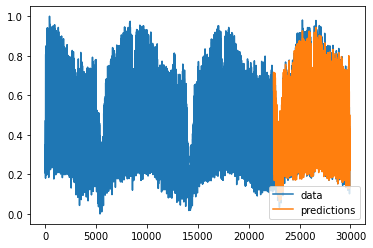

In [48]:
def predict_sample(x, y):
  with tf.GradientTape() as tape:
    weights_pred = hypernet(x)

    kernel0, recurrent_kernel0, b0, w1, b1, w2, b2, w3, b3 = get_parameters(weights_pred)

    # Set the weight predictions as the weight variables on the outer model.
    lstm_model.layers[0].kernel = kernel0
    lstm_model.layers[0].recurrent_kernel = recurrent_kernel0
    lstm_model.layers[0].bias = b0
    lstm_model.layers[1].kernel = w1
    lstm_model.layers[1].bias = b1
    lstm_model.layers[2].kernel = w2
    lstm_model.layers[2].bias = b2
    lstm_model.layers[3].kernel = w3
    lstm_model.layers[3].bias = b3

    # Inference on the outer model.
    preds = lstm_model(x)
  

  return preds


def predict(dataset):
  predictions = []  
  for step, (x, y) in enumerate(tqdm(dataset, desc='Testing')):
      pred = predict_sample(x, y)
      predictions.append(float(pred))

  return np.array(predictions)


test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(1)


def evaluate(pred, y):

  #rescale 
  pred_rescaled = (pred + min_value) * (max_value - min_value)
  y_rescaled = (y + min_value) * (max_value - min_value)


  return float(loss_fn1(y_rescaled, pred_rescaled)), float(loss_fn2(y_rescaled, pred_rescaled))


pred_test = predict(test_dataset)
test_loss1, test_loss2 = evaluate(pred_test, y_test)
print("Test set: MSE ", test_loss1, " MAE ", test_loss2)

y = np.concatenate((y_train, y_test))
s = y.size
x = range(s)
plt.plot(x, y, label='data')
x1 = range(s - pred_test.size, s)
plt.plot(x1, pred_test, label='predictions')
plt.legend()
plt.show()